In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV, RFE
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [ ]:
# -------------------- Read Data --------------------
data_df = pd.read_csv("CO2 Emissions_Canada.csv")
print("Original data shape:", data_df.shape)

# Define features and target variable
features = ["Engine Size(L)", "Cylinders", "Fuel Consumption City (L/100 km)", 
            "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)", 
            "Fuel Consumption Comb (mpg)", "Make", "Model", "Vehicle Class", 
            "Transmission", "Fuel Type"]
target = "CO2 Emissions(g/km)"

# List numerical and categorical features
numeric_features = ["Engine Size(L)", "Cylinders", "Fuel Consumption City (L/100 km)", 
                    "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)", 
                    "Fuel Consumption Comb (mpg)"]
categorical_features = ["Make", "Model", "Vehicle Class", "Transmission", "Fuel Type"]

Original data shape: (7385, 12)


In [ ]:
# -------------------- 1. Data Splitting --------------------
print("\n[1] Data Splitting")
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)


[1] Data Splitting
Training set shape: (5908, 12)
Test set shape: (1477, 12)


In [ ]:
# -------------------- 2. Apply KFold Target Encoding on Training Data --------------------
print("\n[2] Apply KFold Target Encoding on Training Data")

# Initialize KFold with 5 splits, shuffling enabled for randomness
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a copy of the training dataset to store encoded values
train_encoded_df = train_df.copy()

# Perform KFold Target Encoding for each categorical feature
for cat in categorical_features:
    # Create a new column for the encoded values, initially set to NaN
    train_encoded_df[f"{cat}_encoded"] = np.nan  

    # Apply KFold encoding
    for train_idx, val_idx in kf.split(train_df):
        # Select the training fold
        fold_train = train_df.iloc[train_idx]  

        # Compute mean target value for each category in the training fold
        target_mean = fold_train.groupby(cat)[target].mean()  

        # Ensure only valid indices are used to avoid KeyErrors
        valid_idx = train_encoded_df.index.intersection(val_idx)

        # Assign encoded values using the computed mean from the training fold
        train_encoded_df.loc[valid_idx, f"{cat}_encoded"] = train_df.loc[valid_idx, cat].map(target_mean)

    # Handle unseen categories by replacing NaN values with the overall target mean
    train_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)

    print(f"Completed KFold target encoding for feature: {cat}")

# Display a preview of the encoded training dataset
print("\nTraining dataset after KFold target encoding (first 5 rows):")
print(train_encoded_df.head())

# Check and report missing values
print("\nChecking for missing values in the training dataset:")
missing_values = train_encoded_df.isnull().sum()
print(missing_values)

# Display the final status of missing values
if missing_values.sum() == 0:
    print("No missing values found in the training dataset.")
else:
    print("Missing values detected in the training dataset.")


[2] Apply KFold Target Encoding on Training Data
Completed KFold target encoding for feature: Make
Completed KFold target encoding for feature: Model
Completed KFold target encoding for feature: Vehicle Class
Completed KFold target encoding for feature: Transmission
Completed KFold target encoding for feature: Fuel Type

Training dataset after KFold target encoding (first 5 rows):
         Make        Model             Vehicle Class  Engine Size(L)  \
6590      BMW  M240i Coupe                SUBCOMPACT             3.0   
6274   NISSAN     Frontier      PICKUP TRUCK - SMALL             4.0   
2251     AUDI   S4 QUATTRO                   COMPACT             3.0   
3149  PORSCHE     CAYMAN S                TWO-SEATER             3.4   
4362    VOLVO       V90 T5  STATION WAGON - MID-SIZE             2.0   

      Cylinders Transmission Fuel Type  Fuel Consumption City (L/100 km)  \
6590          6          AS8         Z                              11.4   
6274          6           A5  

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13020\852649224.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13020\852649224.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [ ]:
print("Training set shape:", train_encoded_df.shape)

Training set shape: (5908, 17)


In [ ]:
# -------------------- 3. Apply Target Encoding on Test Data --------------------
print("\n[3] Apply Target Encoding on Test Data")
test_encoded_df = test_df.copy()
for cat in categorical_features:
    overall_mapping = train_df.groupby(cat)[target].mean()
    test_encoded_df[cat + "_encoded"] = test_df[cat].map(overall_mapping)
    # Fill missing values with the overall training target mean
    test_encoded_df[cat + "_encoded"].fillna(train_df[target].mean(), inplace=True)
    print(f"Completed target encoding for {cat} in test data")

# Remove original categorical features
train_encoded_df.drop(columns=categorical_features, inplace=True)
test_encoded_df.drop(columns=categorical_features, inplace=True)

print("\nMissing values in test set:")
missing_test_counts = test_encoded_df.isnull().sum()
print(missing_test_counts)

if missing_test_counts.sum() == 0:
    print("No missing values in test set")
else:
    print("There are missing values in test set")


[3] Apply Target Encoding on Test Data
Completed target encoding for Make in test data
Completed target encoding for Model in test data
Completed target encoding for Vehicle Class in test data
Completed target encoding for Transmission in test data
Completed target encoding for Fuel Type in test data

Missing values in test set:
Engine Size(L)                      0
Cylinders                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
Make_encoded                        0
Model_encoded                       0
Vehicle Class_encoded               0
Transmission_encoded                0
Fuel Type_encoded                   0
dtype: int64
No missing values in test set


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13020\579498718.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_encoded_df[cat + "_encoded"].fillna(train_df[target].mean(), inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13020\579498718.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett


[4] Correlation Analysis


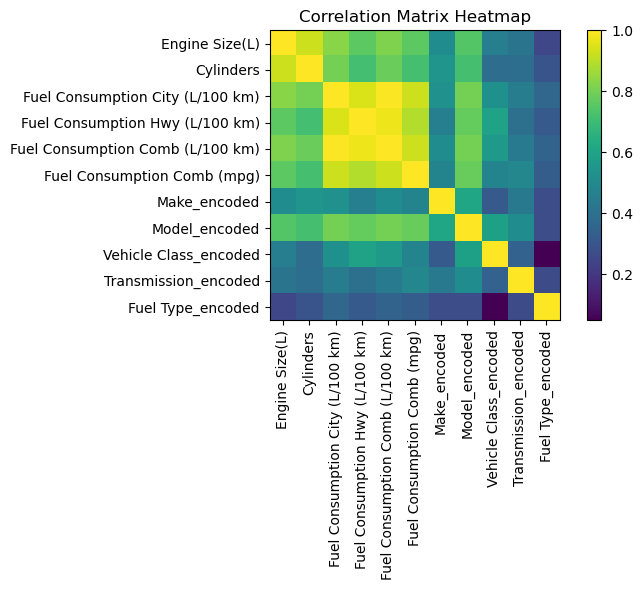

Highly correlated feature pairs:
Engine Size(L) and Cylinders have correlation: 0.93
Fuel Consumption City (L/100 km) and Fuel Consumption Hwy (L/100 km) have correlation: 0.95
Fuel Consumption City (L/100 km) and Fuel Consumption Comb (L/100 km) have correlation: 0.99
Fuel Consumption City (L/100 km) and Fuel Consumption Comb (mpg) have correlation: 0.93
Fuel Consumption Hwy (L/100 km) and Fuel Consumption Comb (L/100 km) have correlation: 0.98
Fuel Consumption Comb (L/100 km) and Fuel Consumption Comb (mpg) have correlation: 0.93
Randomly retained features: ['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Make_encoded', 'Model_encoded', 'Vehicle Class_encoded', 'Transmission_encoded', 'Fuel Type_encoded']
Training set after removing high-correlation features, first 5 rows:
      Engine Size(L)  Fuel Consumption City (L/100 km)  Make_encoded  \
6590             3.0                              11.4    250.939573   
6274             4.0                              14.7    250.9

In [ ]:
# -------------------- 4. Correlation Analysis --------------------
print("\n[4] Correlation Analysis")
# Feature list: numerical features + encoded categorical features
all_features = numeric_features + [cat + "_encoded" for cat in categorical_features]
corr_matrix = train_encoded_df[all_features].corr().abs()

# Plot correlation matrix heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Print feature pairs with correlation > 0.9
print("Highly correlated feature pairs:")
for i, col in enumerate(corr_matrix.columns):
    for j in range(i + 1, len(corr_matrix.columns)):
         other = corr_matrix.columns[j]
         if corr_matrix.loc[col, other] > 0.9:
             print(f"{col} and {other} have correlation: {corr_matrix.loc[col, other]:.2f}")

# -------------------- 4.1 Retain One Feature per High-Correlation Group --------------------
selected_features = []
for col in all_features:
    drop_flag = False
    for kept in selected_features:
        if corr_matrix.loc[col, kept] > 0.9:
            drop_flag = True
            break
    if not drop_flag:
        selected_features.append(col)

print("Randomly retained features:", selected_features)

# Build new training and test sets with the target variable
train_reduced_df = train_encoded_df[selected_features + [target]]
test_reduced_df = test_encoded_df[selected_features + [target]]
print("Training set after removing high-correlation features, first 5 rows:")
print(train_reduced_df.head())


[5] Feature Selection using RFE with Random Forest - Retaining Half the Features
Best features selected by RFE: ['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Model_encoded']
Feature rankings:
Engine Size(L)                      1
Fuel Consumption City (L/100 km)    1
Model_encoded                       1
Fuel Type_encoded                   2
Vehicle Class_encoded               3
Transmission_encoded                4
Make_encoded                        5
dtype: int32


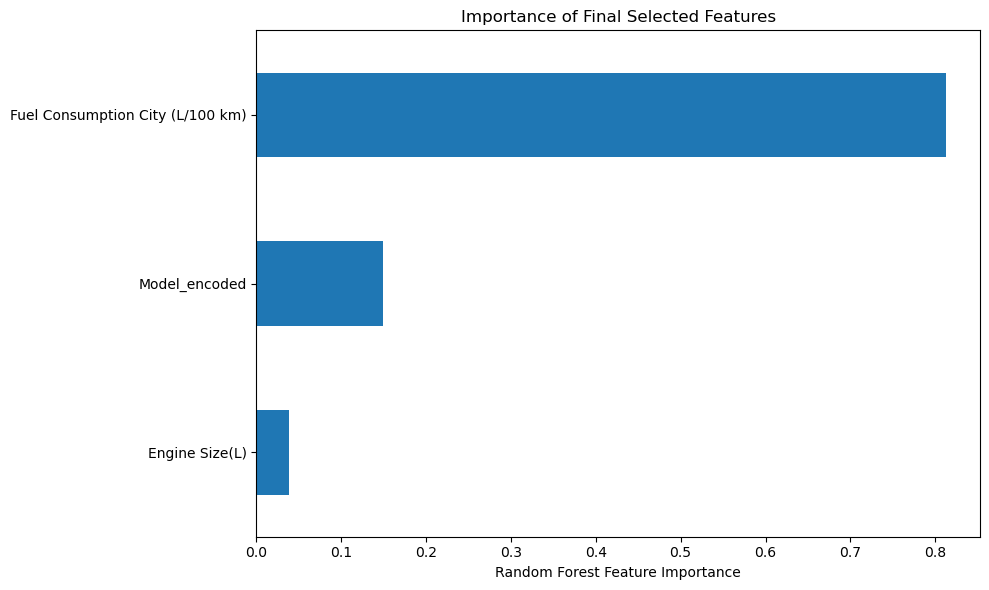

In [ ]:
# -------------------- 5. Feature Selection using RFE with Random Forest --------------------
print("\n[5] Feature Selection using RFE with Random Forest - Retaining Half the Features")
X_train = train_reduced_df.drop(columns=[target])
y_train = train_reduced_df[target]
X_test = test_reduced_df.drop(columns=[target])
y_test = test_reduced_df[target]

# Use Random Forest as the base estimator
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)

# Set number of features to retain as half of the total (rounded down)
num_features_to_select = X_train.shape[1] // 2

rfe = RFE(estimator=rf_selector, n_features_to_select=num_features_to_select, step=1)

rfe.fit(X_train, y_train)

# List the best features selected by RFE
optimal_features = X_train.columns[rfe.support_].tolist()
print("Best features selected by RFE:", optimal_features)

# Print ranking of each feature (1 means selected, higher numbers mean lower importance)
ranking_series = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()
print("Feature rankings:")
print(ranking_series)

# Fit a final Random Forest on the selected features and show their importances
rf_final = RandomForestRegressor(random_state=42)
rf_final.fit(X_train[optimal_features], y_train)
final_importances = pd.Series(rf_final.feature_importances_, index=optimal_features).sort_values(ascending=True)

# Plot the importance of the final selected features
plt.figure(figsize=(10, 6))
final_importances.plot(kind='barh')
plt.xlabel("Random Forest Feature Importance")
plt.title("Importance of Final Selected Features")
plt.tight_layout()
plt.show()

# Build new training and test sets with only the selected features
X_train_final = X_train[optimal_features]
X_test_final = X_test[optimal_features]


In [ ]:
print("Training set shape:", X_train_final.shape)
print("Test set shape:", X_test_final.shape)

Training set shape: (5908, 3)
Test set shape: (1477, 3)
